# Replacing Values w. Rasterio

----------------

```{admonition} Learning Objectives
* Replace and interpolate values in a raster with rasterio
```
```{admonition} Review
* [Geospatial Raster Data](c_rasters.md)
```

----------------

Imagery may sometimes have errors due to factors such as noise, distortion, or sensor errors. Some pixels may have extremely high or low values or no value at all. One way to resolve this issue is to manually replace a pixel value with another pixel value. Another option is to interpolate the pixel value based on the values of the pixel's neighbors.

We'll explore how to replace raster values with `rasterio`.

## Setup

First, we will import our modules (click the + below to show code cell).

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine
from rasterio.fill import fillnodata

Next, we will generate a sample raster to be used (click the + below to show code cell).

In [2]:
# Generate mesh grid for rasters
x = np.linspace(-90, 90, 200)
y = np.linspace(90, -90, 200)
X, Y = np.meshgrid(x, y)

# Generate values for mesh grid
Z1 = np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 = np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)

# Generate raster values
Z = (Z1 - Z2)

# Set transform
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

# Save raster
with rasterio.open(
        "../temp/replace_values_raster.tif",
        mode="w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        crs="+proj=latlong",
        transform=transform,
) as new_dataset:
        new_dataset.write(Z, 1)

## Replace values with rasterio

We will open the example raster that we generated above.

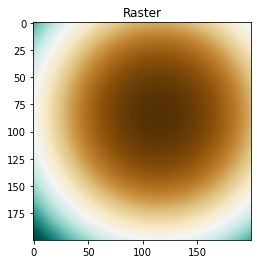

In [3]:
# Open raster and plot
raster_file = rasterio.open("../temp/replace_values_raster.tif")
raster = raster_file.read(1)
plt.imshow(raster, cmap="BrBG")
plt.title("Raster")
plt.show()

### Replace values with a specified number

Let's say that we want to change the pixel value at row 150, column 100 because it's wrong. We can simply call that pixel value by its row index and column index.

In [4]:
# Replace value with 0 at one location
raster[150, 100] = 0
raster[150, 100]

0.0

We can also change multiple pixel values by slicing. In this case, we replace the values in rows 99-101 and columns 6-8 with the value `0`.

In [5]:
# Replace values with 0 at multiple locations
raster[99:102, 6:9] = 0
raster[99:102, 6:9]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Finally, we can change any pixel values that are of a certain value.

In [6]:
# Replace values with 0 if they are greater than or equal to certain number (in this case, 13776)
raster[raster >= 13776] = 0
raster

array([[    0.        , 13618.93851165, 13463.25153405, ...,
         9371.19123254,  9484.9083609 ,  9600.        ],
       [13660.9083609 , 13503.84687255, 13348.15989495, ...,
         9256.09959344,  9369.8167218 ,  9484.9083609 ],
       [13547.19123254, 13390.1297442 , 13234.4427666 , ...,
         9142.38246509,  9256.09959344,  9371.19123254],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        13234.4427666 , 13348.15989495, 13463.25153405],
       [    0.        ,     0.        ,     0.        , ...,
        13390.1297442 , 13503.84687255, 13618.93851165],
       [    0.        ,     0.        ,     0.        , ...,
        13547.19123254, 13660.9083609 ,     0.        ]])

### Replace values through interpolation

Sometimes, we don't know or have an exact value to replace pixel values with. We can "fill in" those pixel values through interpolation. Recall that interpolation uses the pixel values surrounding a certain pixel to determine the value for that certain pixel.

In the following example, we will interpolate the values for the pixels that were previously set to `0`.

`Rasterio` provides a function `fillnodata()` that does this for us. In addition to specifying a raster, we also need to provide a mask, which tells the function which pixel values need to be filled in. The mask can either be an array of Boolean values (`True` or `False`, where `False` indicates pixels to be filled in) or numbers (where values equal to `0` indicate pixels to be filled in and values equal to `1` indicate pixels to ignore).

For more information this function, see the [function documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.fill.html).

```{important} Mask must be in the same shape (number of rows and columns) as that of the input raster.
```

Below, we will interpolate the pixels whose values were previously set to `0`.

In [7]:
# Create a Boolean mask (True/False), with a value of False for pixels that equal 0
mask_boolean = (raster != 0)
mask_boolean

array([[False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False]])

In [8]:
# Create a value mask, with a value of 0 for pixels that equal 0
mask_numbers = np.zeros_like(raster)
mask_numbers[raster > 0] = 255
mask_numbers

array([[  0., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255.,   0.]])

In [9]:
# Fill in missing values with interpolation
# Can use either a Boolean mask or a value mask
fillnodata(raster, mask = mask_boolean, max_search_distance = 1000)

array([[13604.37988281, 13618.93847656, 13463.25195312, ...,
         9371.19140625,  9484.90820312,  9600.        ],
       [13660.90820312, 13503.84667969, 13348.16015625, ...,
         9256.09960938,  9369.81640625,  9484.90820312],
       [13547.19140625, 13390.12988281, 13234.44238281, ...,
         9142.3828125 ,  9256.09960938,  9371.19140625],
       ...,
       [13687.77148438, 13674.72460938, 13698.35644531, ...,
        13234.44238281, 13348.16015625, 13463.25195312],
       [13698.04101562, 13686.17285156, 13709.640625  , ...,
        13390.12988281, 13503.84667969, 13618.93847656],
       [13688.7734375 , 13672.33984375, 13704.9375    , ...,
        13547.19140625, 13660.90820312, 13618.93847656]])

Finally, we can check the raster values to see the interpolated values.

In [10]:
# Print raster array
raster

array([[13604.37988281, 13618.93847656, 13463.25195312, ...,
         9371.19140625,  9484.90820312,  9600.        ],
       [13660.90820312, 13503.84667969, 13348.16015625, ...,
         9256.09960938,  9369.81640625,  9484.90820312],
       [13547.19140625, 13390.12988281, 13234.44238281, ...,
         9142.3828125 ,  9256.09960938,  9371.19140625],
       ...,
       [13687.77148438, 13674.72460938, 13698.35644531, ...,
        13234.44238281, 13348.16015625, 13463.25195312],
       [13698.04101562, 13686.17285156, 13709.640625  , ...,
        13390.12988281, 13503.84667969, 13618.93847656],
       [13688.7734375 , 13672.33984375, 13704.9375    , ...,
        13547.19140625, 13660.90820312, 13618.93847656]])

In [11]:
# Print subset of raster around row 150, column 100
raster[148:153, 98:103]

array([[2835.38891602, 2813.02954102, 2792.04467773, 2772.43432617,
        2754.19824219],
       [2923.72485352, 2901.36547852, 2880.38061523, 2860.77026367,
        2842.53417969],
       [3013.43530273, 2991.07592773, 2978.80517578, 2950.48071289,
        2932.24462891],
       [3104.52050781, 3082.16088867, 3061.17602539, 3041.56567383,
        3023.32983398],
       [3196.97998047, 3174.62036133, 3153.63549805, 3134.02514648,
        3115.78930664]])

In [12]:
# Print subset of raster around rows 99-101, columns 6-8]
raster[97:104, 4:11]

array([[8391.83398438, 8240.27050781, 8090.08154297, 7941.26757812,
        7793.82763672, 7647.76220703, 7503.07128906],
       [8410.0703125 , 8258.50683594, 8108.31787109, 7959.50341797,
        7812.06347656, 7665.99804688, 7521.30712891],
       [8429.68066406, 8278.1171875 , 8072.66064453, 7934.33056641,
        7755.44726562, 7685.60839844, 7540.91748047],
       [8450.66503906, 8299.1015625 , 8203.32421875, 7863.87109375,
        7767.40527344, 7706.59326172, 7561.90234375],
       [8473.02441406, 8321.4609375 , 8150.89306641, 7999.92822266,
        7799.43115234, 7728.95263672, 7584.26171875],
       [8496.75878906, 8345.1953125 , 8195.00683594, 8046.19189453,
        7898.75195312, 7752.68652344, 7607.99560547],
       [8521.8671875 , 8370.30371094, 8220.11523438, 8071.30029297,
        7923.86035156, 7777.79492188, 7633.10400391]])

## Replace values with `GeoWombat`

For replacing raster values with `GeoWombat`, see the chapter on [Editing Rasters and Remotely Sensed Data](f_rs_edit.md).